In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

TypeError: int() argument must be a string or a number, not 'NoneType'

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [27]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [28]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [29]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [30]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [31]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [32]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [33]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [36]:
j=FOLD
validpreds={}

In [37]:
p = Pool(4,maxtasksperchild=1)





2
1
(1, 829, 517) (60, 829, 517)
(1, 829, 517) (60, 829, 517)
72 (829, 517, 72) (829, 517)
72 (829, 517, 72) (829, 517)
(18,) 0.06769826 14.804288
(18,) 0.06769826 14.804288
(829, 517, 18)
(829, 517, 18)
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (311610, 2) (78020, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)
train/valid # (199874, 2) (50866, 2)
rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1561
0
rand split across time
train has 199874 records out of 389630 records
valid has 50866 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1561
0
(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 1, 18) (199874, 7, 32) (199874, 1) (199874, 1)
(199874, 242) (199874,) (199874,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(199874, 242) (199874,) (199874,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(50866, 1, 18) (50866, 7, 32) (50866, 1) (50866, 1)
(50866, 242) (50866,) (50866,)
(6632, 1, 18) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 242) (6632,) (6632,)
(5803, 1, 18) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 242) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3923	valid-rmse:2.39917
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[0]	train-rmse:2.36999	valid-rmse:2.376
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.718208	valid-rmse:0.728867
[50]	train-rmse:0.719189	valid-rmse:0.728242
[100]	train-rmse:0.498336	valid-rmse:0.521079
[150]	tra

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896076  0.033034  0.179757    7  2017-04-16
472     2.507290  2.539624 -0.032333  0.173172    1  2017-04-17
473     2.661330  2.648243  0.013087  0.189469    2  2017-04-18
474     2.754815  2.729545  0.025269  0.167165    3  2017-04-19
475     2.713762  2.706170  0.007592  0.182078    4  2017-04-20
476     2.999000  2.990221  0.008779  0.126712    5  2017-04-21
477     3.075529  3.095958 -0.020429  0.150565    6  2017-04-22

0.166988447309


pred         y     error    error2  day        date
dayidx                                                         
471     2.896076  2.929110  0.033034  0.179757    7  2017-04-16
472     2.539624  2.507290 -0.032333  0.173172    1  2017-04-17
473     2.648243  2.661330  0.013087  0.189469    2  2017-04-18
474     2.729545  2.754815  0.025269  0.167165    3  2017-04-19
475     2.706170  2.713762  0.007592  0.182078    4  2017-04-20
476     2.990221  2.999000  0.008779  0.126712    5  2017-04-21
477     3.095958  3.075529 -0.020429  0.150565    6  2017-04-22

(829, 242)
[650]	train-rmse:0.422172	valid-rmse:0.502414
[700]	train-rmse:0.417763	valid-rmse:0.5023
[750]	train-rmse:0.413088	valid-rmse:0.502259
[800]	train-rmse:0.408703	valid-rmse:0.502172
[850]	train-rmse:0.40439	valid-rmse:0.502138
[900]	train-rmse:0.400445	valid-rmse:0.502038
[950]	train-rmse:0.396438	valid-rmse:0.502005
Stopping. Best iteration:
[948]	train-rmse:0.396529	valid-rmse:0.501998

0.15723512 0.25200167
[0.25200167]
-1 mean score 0.25200167
0.146403804421


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907307  0.021803  0.157239    7  2017-04-16
472     2.507290  2.538682 -0.031391  0.143760    1  2017-04-17
473     2.661330  2.655165  0.006165  0.154809    2  2017-04-18
474     2.754815  2.729415  0.025399  0.155840    3  2017-04-19
475     2.713762  2.698756  0.015005  0.165909    4  2017-04-20
476     2.999000  2.988030  0.010969  0.109486    5  2017-04-21
477     3.075529  3.085280 -0.009751  0.137784    6  2017-04-22

0.146403804421


pred         y     error    error2  day        date
dayidx                                                         
471     2.907307  2.929110  0.021803  0.157239    7  2017-04-16
472     2.538682  2.507290 -0.031391  0.143760    1  2017-04-17
473     2.655165  2.661330  0.006165  0.154809    2  2017-04-18
474     2.729415  2.754815  0.025399  0.155840    3  2017-04-19
475     2.698756  2.713762  0.015005  0.165909    4  2017-04-20
476     2.988030  2.999000  0.010969  0.109486    5  2017-04-21
477     3.085280  3.075529 -0.009751  0.137784    6  2017-04-22

(829, 242)


In [38]:
results=p.map(ff, range(1,40),chunksize=1)

In [39]:
p.close()

In [40]:
validpreds=dict(results)

In [42]:
pickle.dump(validpreds, open('3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

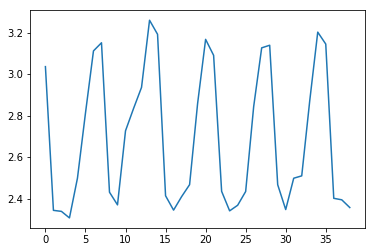

In [25]:
plt.plot(testpreds[129])

In [26]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [27]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.015153   
air_0164b9927d20bcc3_2017-04-23              1.159538   
air_0241aa3964b7f861_2017-04-23              2.201394   
air_0328696196e46f18_2017-04-23              2.177014   
air_034a3d5b40d5b1b1_2017-04-23              3.288455   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.501875  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   2.188459  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   8.037601  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.819930  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  25.801427

In [28]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [29]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [30]:
submission.to_csv("../submission/3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')